In [6]:
%matplotlib inline
from ENet import enet, train_utils, train
from matplotlib import pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.utils import to_categorical
from keras import callbacks
import numpy as np
import os

#### Getting the data from file to training format

The very first step is just the data from the folders into the generator that can spit out a bunch of images in batches of a specified size. For more information on how the generator works and why it's used, please look at the Generator_tutorial.ipynb. 

DEFINITIONS: 
- Batch size: The size of a set of data that will be read by the model. The model doesn't just take in a single image at a time, but a set of images. After each batch, the cost and error will be evaluated. There is a lot of testing to be done with this parameter, but I usually opt for 16 since that's what I saw in some tutorials. I believe the wisdom is that smaller batch size may cause more variability in updates while too large of a batch size may lose information in the individual images.

- train size: real number [0,1.0]; the ratio of images to be used for training 
- test/validation size: real number [0,1.0]; 1.0 - train size. The rest of the data not used for training will be used to evaluate the model to see how well the model generalizes


In [10]:
original = 'sampleData/segmentation_data/original/'
labeled = 'sampleData/segmentation_data/labeled/'
traingen, _ = train.train_val_generators(original, labeled, train_size=1.0, batch_size=4)

In [12]:
# This is to store things about the model. Checkpoint just stores the model in intermediate positions
# ealy stop cuts training short so we don't have to trian if the learning has stopped e.g. stop on the 70th epoch even
# if we told the model to train for 100 epochs because the loss is not getting any smaller

storage_path = 'serialized_objects/logs/FINAL_weights_{acc:.2f}.hdf5'
checkpoint = callbacks.ModelCheckpoint(storage_path, monitor='acc', period=4, save_best_only=True, save_weights_only=True)
early_stop = callbacks.EarlyStopping(monitor='loss',min_delta=.007, patience=4, mode='min')
cbacks = [checkpoint, early_stop]

In [11]:
print 'training size:',traingen.n
print 'train batch size:', traingen.batch_size

training size: 4
train batch size: 4


### MODEL DEFINITION

In [13]:
model, name = enet.autoencoder(2, (256,256))

(TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(64)]), TensorShape([Dimension(None), Dimension(128), Dimension(128), Dimension(16)]), TensorShape([Dimension(None), Dimension(128), Dimension(128), Dimension(16)]), 64)
(TensorShape([Dimension(None), Dimension(64), Dimension(16), Dimension(64)]), 'pad', (0, 48))
(TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(128)]), TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(64)]), TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(64)]), 128)
(TensorShape([Dimension(None), Dimension(32), Dimension(64), Dimension(32)]), 'pad', (0, 64))
bottleneck 2.x and 3.x   
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
_____

In [14]:
# history = model.fit_generator(
#         generator=traingen,
#         steps_per_epoch=6,
#         epochs=100,
#         verbose=1,
#         callbacks=cbacks)

Epoch 1/100
6/6 [==============================] - 51s - loss: 0.7126 - acc: 0.5682 - mean_squared_error: 0.2528    
Epoch 2/100
6/6 [==============================] - 18s - loss: 0.6627 - acc: 0.6027 - mean_squared_error: 0.2335    
Epoch 3/100
6/6 [==============================] - 18s - loss: 0.6227 - acc: 0.6397 - mean_squared_error: 0.2169    
Epoch 4/100
6/6 [==============================] - 47s - loss: 0.5900 - acc: 0.6725 - mean_squared_error: 0.2035    
Epoch 5/100
6/6 [==============================] - 18s - loss: 0.5570 - acc: 0.7048 - mean_squared_error: 0.1897    
Epoch 6/100
6/6 [==============================] - 18s - loss: 0.5317 - acc: 0.7278 - mean_squared_error: 0.1792    
Epoch 7/100
6/6 [==============================] - 18s - loss: 0.5002 - acc: 0.7494 - mean_squared_error: 0.1664    
Epoch 8/100
6/6 [==============================] - 18s - loss: 0.4807 - acc: 0.7576 - mean_squared_error: 0.1590    
Epoch 9/100
6/6 [==============================] - 18s - loss: 0

In [15]:
# weights_path = 'serialized_objects/logs/FINAL_weights_0.92.hdf5'
# model.load_weights(weights_path)

In [16]:
def output_to_mask(output, shape=(256,256), threshold=.5):
    yval = [1 if l[1] >= threshold else 0 for l in output]
    ymask = np.reshape(yval,(256,256))
    return ymask.astype(bool)

In [17]:
unseen_file = 'sampleData/segmentation_data/original/diseased_image_13.jpg'
tarr = np.array([train_utils.get_training_image(unseen_file, (256,256))])

In [18]:
output = model.predict(tarr)

In [19]:
print output.shape
output

(1, 65536, 2)


array([[[ 0.98851341,  0.01148655],
        [ 0.98551905,  0.01448093],
        [ 0.99623364,  0.00376634],
        ..., 
        [ 0.98977542,  0.01022452],
        [ 0.99443603,  0.00556396],
        [ 0.99224102,  0.00775894]]], dtype=float32)

In [20]:
ymask = output_to_mask(output[0], threshold=.8)
ymask = train_utils.smooth_mask(ymask, threshold=.1, self_weight=.01, size=11)

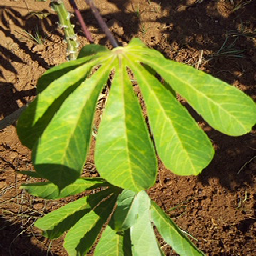

In [21]:
array_to_img(tarr[0])

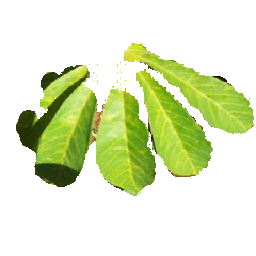

In [22]:
array_to_img(train_utils.extract_leaf(tarr[0], ymask))